In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression 
import tensorflow as tf
import copy

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

Date : year-month-day

Rented Bike count - Count of bikes rented at each hour

Hour - Hour of he day

Temperature-Temperature in Celsius

Humidity - %

Windspeed - m/s

Visibility - 10m

Dew point temperature - Celsius 

Solar radiation - MJ/m2

Rainfall - mm

Snowfall - cm

Seasons - Winter, Spring, Summer, Autumn

Holiday - Holiday/No holiday

Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [129]:
dataset_cols = ["bike_count", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("./file/SeoulBikeData.csv", encoding='ISO-8859-1').drop(["Date", "Holiday", "Seasons", "Hour"], axis=1)
df.columns =  dataset_cols

df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [130]:
df["functional"].unique()

array(['Yes', 'No'], dtype=object)

In [131]:
df["functional"] = (df["functional"] == "Yes").astype(int)

df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [132]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

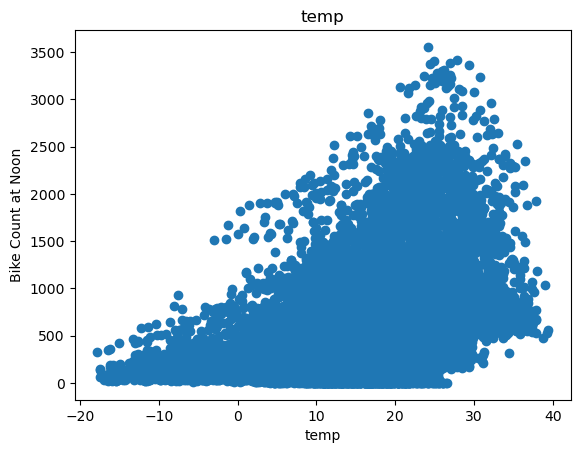

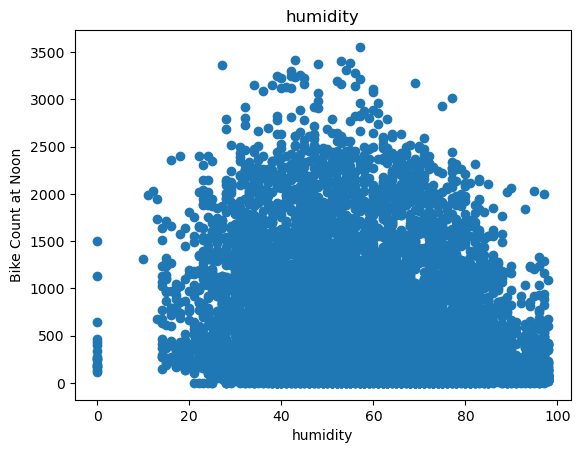

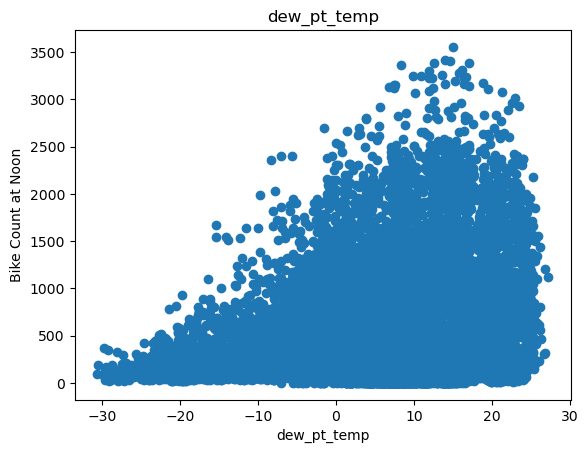

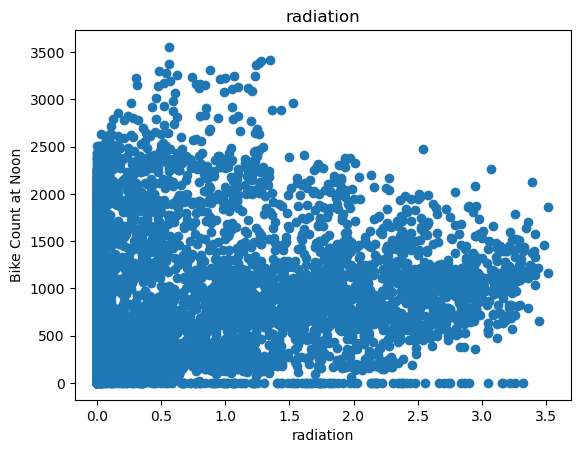

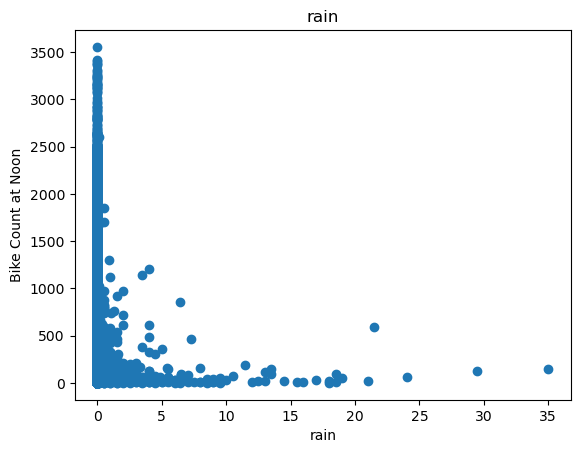

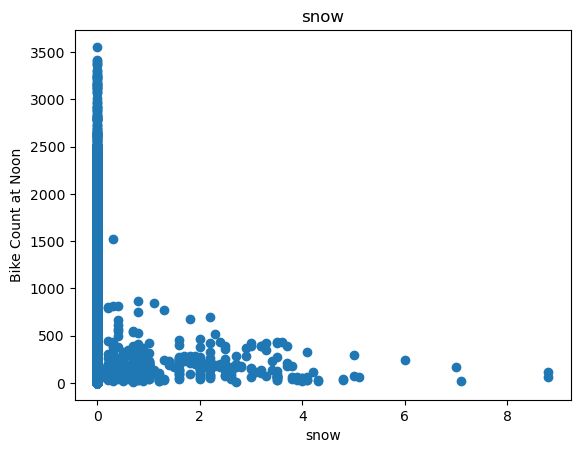

In [133]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

# Train/Valid/Test Dataset for Simple Linear Regression

In [134]:
## Shuffle the DataFrame using sample() method, frac=1 keeps all rows, and random_state ensures reproducibility
df_shuffled = df.sample(frac=1, random_state=42)

# Split the shuffled DataFrame into 3 parts:
# 60% for training, 20% for validation, and 20% for testing
train, valid, test = np.split(df_shuffled,[
                               int(0.6 * len(df)),  # First 60% for training
                               int(0.8 * len(df))
]) # Next 20% for validation, rest for testing

/nix/store/gdckiap2g28wl5b5i8rhm98ijxkln6v7-python3.11-numpy-1.26.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [135]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)

    if not x_labels:
        X = dataframe[[ c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values

    Y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,Y))

    return data, X, Y

In [136]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [137]:
print(x_train_temp)

[[-1.1]
 [ 6.2]
 [ 6.6]
 ...
 [25.4]
 [25.3]
 [14.1]]


In [138]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [139]:
print(temp_reg.coef_, temp_reg.intercept_)

[[29.28485988]] [328.20564844]


In [140]:
temp_reg.score(x_test_temp, y_test_temp)

0.29212643453792775

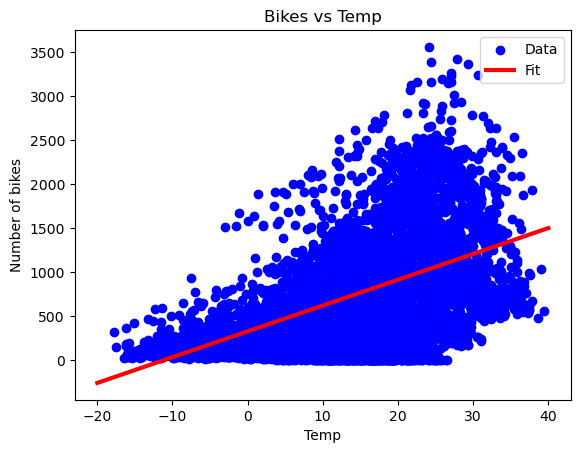

In [141]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
y = temp_reg.predict(np.array(x).reshape(-1, 1))
plt.plot(x, y, label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()